In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import kagglehub
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore")
np.random.seed(42)
export_path = "../../exports/revenue"
image_path = os.path.join(export_path,"visualizations")
metrices_path = os.path.join(export_path,"metrices")
os.makedirs(export_path, exist_ok=True)
os.makedirs(image_path, exist_ok=True)
os.makedirs(metrices_path, exist_ok=True)

In [4]:

path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("Dataset path:", path)

items    = pd.read_csv(os.path.join(path, 'olist_order_items_dataset.csv'))
orders   = pd.read_csv(os.path.join(path, 'olist_orders_dataset.csv'))
reviews  = pd.read_csv(os.path.join(path, 'olist_order_reviews_dataset.csv'))
sellers  = pd.read_csv(os.path.join(path, 'olist_sellers_dataset.csv'))


Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Dataset path: /kaggle/input/brazilian-ecommerce


In [5]:
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
]
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

items['shipping_limit_date'] = pd.to_datetime(
    items['shipping_limit_date'], errors='coerce'
)


delivered = orders[orders['order_status'] == 'delivered'].copy()


df = items.merge(delivered, on='order_id', how='inner')


total_revenue = (
    df.groupby('seller_id')['price']
    .sum()
    .rename('total_revenue')
)


total_orders = (
    df.groupby('seller_id')['order_id']
    .nunique()
    .rename('total_orders')
)


order_revenue = df.groupby(['seller_id', 'order_id'])['price'].sum().reset_index()
avg_order_value = (
    order_revenue.groupby('seller_id')['price']
    .mean()
    .rename('avg_order_value')
)


df['delivery_time_days'] = (
    df['order_delivered_customer_date'] - df['order_delivered_carrier_date']
).dt.total_seconds() / 86400

avg_delivery_time = (
    df.groupby('seller_id')['delivery_time_days']
    .mean()
    .rename('avg_delivery_time_days')
)

In [6]:
df['is_late'] = (
    df['order_delivered_customer_date'] > df['order_estimated_delivery_date']
).astype(int)

late_rate = (
    df.groupby('seller_id')['is_late']
    .mean()
    .rename('late_delivery_rate')
)


order_freight = df.groupby(['seller_id', 'order_id'])['freight_value'].sum().reset_index()
avg_freight_per_order = (
    order_freight.groupby('seller_id')['freight_value']
    .mean()
    .rename('avg_freight_per_order')
)


df['processing_time_days'] = (
    df['order_delivered_carrier_date'] - df['order_approved_at']
).dt.total_seconds() / 86400

avg_processing_time = (
    df.groupby('seller_id')['processing_time_days']
    .mean()
    .rename('avg_processing_time_days')
)


reviews_orders = reviews[['order_id', 'review_score']].merge(
    delivered[['order_id']], on='order_id', how='inner'
)
reviews_sellers = reviews_orders.merge(
    df[['order_id', 'seller_id']].drop_duplicates(),
    on='order_id', how='inner'
)

avg_review_score = (
    reviews_sellers.groupby('seller_id')['review_score']
    .mean()
    .rename('avg_review_score')
)


review_count = (
    reviews_sellers.groupby('seller_id')['review_score']
    .count()
    .rename('review_count')
)


In [7]:
feature_list = [
    total_revenue,
    total_orders,
    avg_order_value,
    avg_delivery_time,
    late_rate,
    avg_freight_per_order,
    avg_processing_time,
    avg_review_score,
    review_count,
]

seller_features = pd.concat(feature_list, axis=1).reset_index()
seller_features.columns = [
    'seller_id',
    'total_revenue',
    'total_orders',
    'avg_order_value',
    'avg_delivery_time_days',
    'late_delivery_rate',
    'avg_freight_per_order',
    'avg_processing_time_days',
    'avg_review_score',
    'review_count',
]


seller_features = seller_features.dropna(subset=['total_revenue', 'total_orders'])


numeric_cols = seller_features.select_dtypes(include='number').columns
seller_features[numeric_cols] = seller_features[numeric_cols].fillna(
    seller_features[numeric_cols].median()
)

print("\n=== Seller Feature Matrix ===")
print(f"Shape: {seller_features.shape}")
print("\nFirst 5 rows:")
print(seller_features.head())
print("\nDescriptive Statistics:")
print(seller_features.describe().round(2))
print("\nMissing Values:")
print(seller_features.isnull().sum())


# output_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'seller_features.csv')
# seller_features.to_csv(output_path, index=False)
# print(f"\nDataset saved to: {output_path}")


=== Seller Feature Matrix ===
Shape: (2970, 10)

First 5 rows:
                          seller_id  total_revenue  total_orders  \
0  0015a82c2db000af6aaaf3ae2ecb0532        2685.00             3   
1  001cca7ae9ae17fb1caed9dfb1094831       24487.03           195   
2  002100f778ceb8431b7a1020ff7ab48f        1216.60            50   
3  003554e2dce176b5555353e4f3555ac8         120.00             1   
4  004c9cd9d87a3c30c522c48c4fc07416       19569.73           156   

   avg_order_value  avg_delivery_time_days  late_delivery_rate  \
0       895.000000                7.433295            0.000000   
1       125.574513               10.459199            0.055556   
2        24.332000               11.697006            0.166667   
3       120.000000                4.110243            0.000000   
4       125.446987               12.683389            0.077381   

   avg_freight_per_order  avg_processing_time_days  avg_review_score  \
0              21.020000                  2.804352        

In [8]:
seller_features

,seller_id,total_revenue,total_orders,avg_order_value,avg_delivery_time_days,late_delivery_rate,avg_freight_per_order,avg_processing_time_days,avg_review_score,review_count
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,3,895.000000,7.433295,0.000000,21.020000,2.804352,3.666667,3.0
1,001cca7ae9ae17fb1caed9dfb1094831,24487.03,195,125.574513,10.459199,0.055556,44.389077,2.183837,4.062500,192.0
2,002100f778ceb8431b7a1020ff7ab48f,1216.60,50,24.332000,11.697006,0.166667,15.571200,3.547857,3.960784,51.0
3,003554e2dce176b5555353e4f3555ac8,120.00,1,120.000000,4.110243,0.000000,19.380000,0.523623,5.000000,1.0
4,004c9cd9d87a3c30c522c48c4fc07416,19569.73,156,125.446987,12.683389,0.077381,22.591603,1.393212,4.150000,160.0
...,...,...,...,...,...,...,...,...,...,...
2965,ffc470761de7d0232558ba5e786e57b7,1529.13,27,56.634444,8.460351,0.066667,15.595926,1.096223,4.444444,27.0
2966,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,18,116.733333,5.883043,0.000000,40.414444,4.053417,4.333333,18.0
2967,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,14,131.418571,11.210362,0.142857,29.977857,6.152881,4.214286,14.0
2968,fffd5413c0700ac820c7069d66d98c89,8535.00,57,149.736842,11.402549,0.137931,45.443860,1.960300,3.892857,56.0


In [9]:
FEATURE_COLS = [
    "total_revenue",
    "total_orders",
    "avg_order_value",
    "avg_delivery_time_days",
    "late_delivery_rate",
    "avg_freight_per_order",
    "avg_processing_time_days",
    "avg_review_score",
    "review_count",
]


In [10]:
# df = pd.read_csv('seller_features.csv')
df = seller_features.copy()
print(f"Loaded {len(df):,} sellers  |  Features: {FEATURE_COLS}\n")
print("Descriptive stats:")
print(df[FEATURE_COLS].describe().round(2))
print()

df_clean = df.copy()
for col in FEATURE_COLS:
    q99 = df_clean[col].quantile(0.99)
    q01 = df_clean[col].quantile(0.01)
    df_clean[col] = df_clean[col].clip(lower=q01, upper=q99)

X_raw = df_clean[FEATURE_COLS].values


Loaded 2,970 sellers  |  Features: ['total_revenue', 'total_orders', 'avg_order_value', 'avg_delivery_time_days', 'late_delivery_rate', 'avg_freight_per_order', 'avg_processing_time_days', 'avg_review_score', 'review_count']

Descriptive stats:
       total_revenue  total_orders  avg_order_value  avg_delivery_time_days  \
count        2970.00       2970.00          2970.00                 2970.00   
mean         4451.68         32.94           195.52                    8.51   
std         13926.97        105.41           368.47                    5.70   
min             6.50          1.00             6.00                   -4.94   
25%           219.80          2.00            60.08                    5.63   
50%           846.18          7.00           105.14                    7.90   
75%          3497.88         22.00           187.58                   10.37   
max        226987.93       1819.00          6735.00                  186.40   

       late_delivery_rate  avg_freight_per_

In [11]:

scaler   = RobustScaler()
X_scaled = scaler.fit_transform(X_raw)

K_RANGE     = range(2, 11)
inertias    = []
sil_scores  = []

print("Searching for optimal k...")
for k in K_RANGE:
    km = KMeans(n_clusters=k, init="k-means++", n_init=15, max_iter=500, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    print(f"  k={k:2d}  inertia={km.inertia_:>12.1f}  silhouette={sil_scores[-1]:.4f}")


inertia_arr = np.array(inertias)
delta1 = np.diff(inertia_arr)
delta2 = np.diff(delta1)
elbow_k = list(K_RANGE)[np.argmax(np.abs(delta2)) + 1]

best_sil_k = list(K_RANGE)[np.argmax(sil_scores)]

print(f"\nElbow suggests k = {elbow_k}")
print(f"Best silhouette at k = {best_sil_k}  (score = {max(sil_scores):.4f})")

CHOSEN_K = best_sil_k if best_sil_k == elbow_k else (elbow_k if elbow_k <= 5 else 3)
print(f"→ Using k = {CHOSEN_K}\n")


Searching for optimal k...
  k= 2  inertia=     63927.2  silhouette=0.7265
  k= 3  inertia=     51438.0  silhouette=0.5019
  k= 4  inertia=     41168.5  silhouette=0.5169
  k= 5  inertia=     34499.2  silhouette=0.5042
  k= 6  inertia=     30943.9  silhouette=0.3832
  k= 7  inertia=     28546.8  silhouette=0.3613
  k= 8  inertia=     26491.7  silhouette=0.3135
  k= 9  inertia=     24494.0  silhouette=0.3160
  k=10  inertia=     23052.0  silhouette=0.3096

Elbow suggests k = 4
Best silhouette at k = 2  (score = 0.7265)
→ Using k = 4



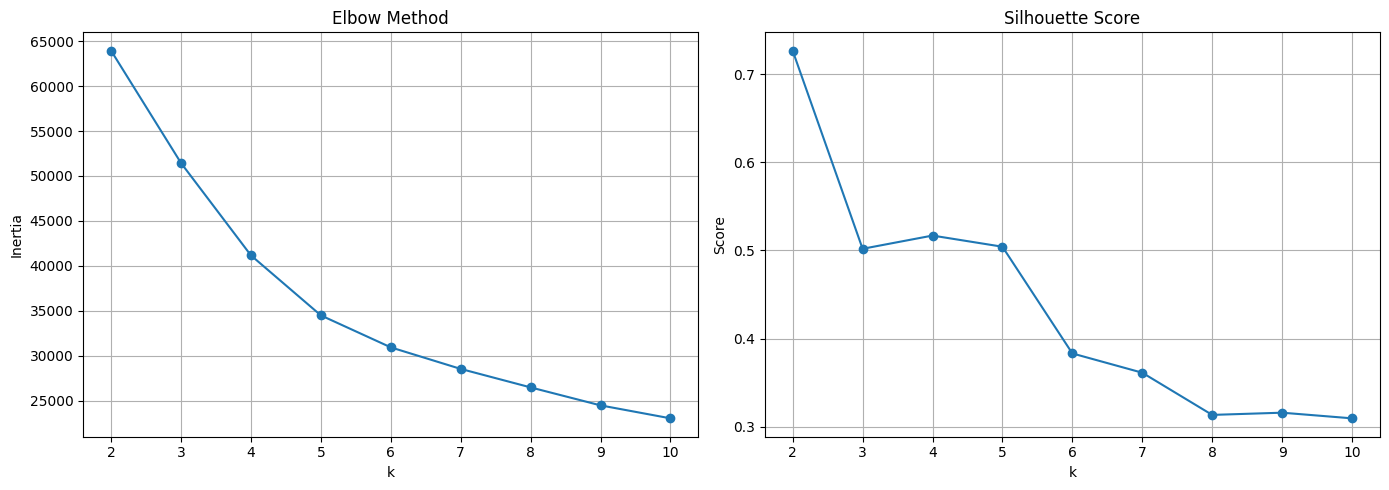

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Elbow
axes[0].plot(list(K_RANGE), inertias, marker='o')
axes[0].set_title("Elbow Method")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")
axes[0].grid(True)

# Silhouette
axes[1].plot(list(K_RANGE), sil_scores, marker='o')
axes[1].set_title("Silhouette Score")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Score")
axes[1].grid(True)

plt.tight_layout()
fig.savefig(os.path.join(image_path, "elbow_silhouette_plot.png"), dpi=300, bbox_inches="tight")
plt.show()

In [14]:
km = KMeans(n_clusters=best_sil_k, init="k-means++", n_init=15, max_iter=500, random_state=42)
labels = km.fit_predict(X_scaled)

In [15]:
df['labels'] = labels

In [16]:
cluster_means = df.groupby("labels").mean(numeric_only=True).round(2)
print(cluster_means)

        total_revenue  total_orders  avg_order_value  avg_delivery_time_days  \
labels                                                                         
0             2473.95         16.70           198.24                    8.46   
1            44132.61        358.59           140.95                    9.48   

        late_delivery_rate  avg_freight_per_order  avg_processing_time_days  \
labels                                                                        
0                     0.08                  26.78                      3.24   
1                     0.08                  21.84                      2.78   

        avg_review_score  review_count  
labels                                  
0                   4.18         16.68  
1                   4.12        358.53  


In [18]:
cluster_revenue_share = df.groupby("labels")["total_revenue"].sum()
cluster_revenue_share = cluster_revenue_share / cluster_revenue_share.sum()

print(cluster_revenue_share)

labels
0    0.52935
1    0.47065
Name: total_revenue, dtype: float64


In [19]:
labels = df.labels

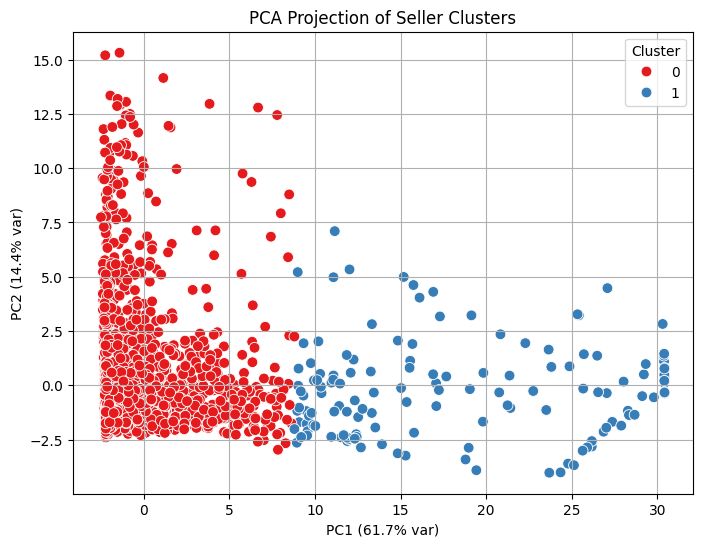

In [21]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster"] = labels

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="Set1",
    s=60
)

plt.title("PCA Projection of Seller Clusters")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Cluster")
plt.grid(True)

file_path_pca = os.path.join(image_path, "pca_projection_seller_cluster_k2.png")
plt.savefig(file_path_pca, dpi=300, bbox_inches="tight")

plt.show()

In [22]:
silhouette_score(X_scaled, labels)

np.float64(0.7265018257499445)

In [23]:
segment_names = {
    0: "Emerging Seller",
    1: "High-Impact Seller"
}

df["seller_segment"] = df["labels"].map(segment_names)

In [24]:
cluster_profile = pd.DataFrame(X_scaled, columns=[
    "total_revenue",
    "total_orders",
    "avg_order_value",
    "avg_delivery_time_days",
    "late_delivery_rate",
    "avg_freight_per_order",
    "avg_processing_time_days",
    "avg_review_score",
    "review_count"
])

cluster_profile["cluster"] = labels

cluster_means_scaled = cluster_profile.groupby("cluster").mean()

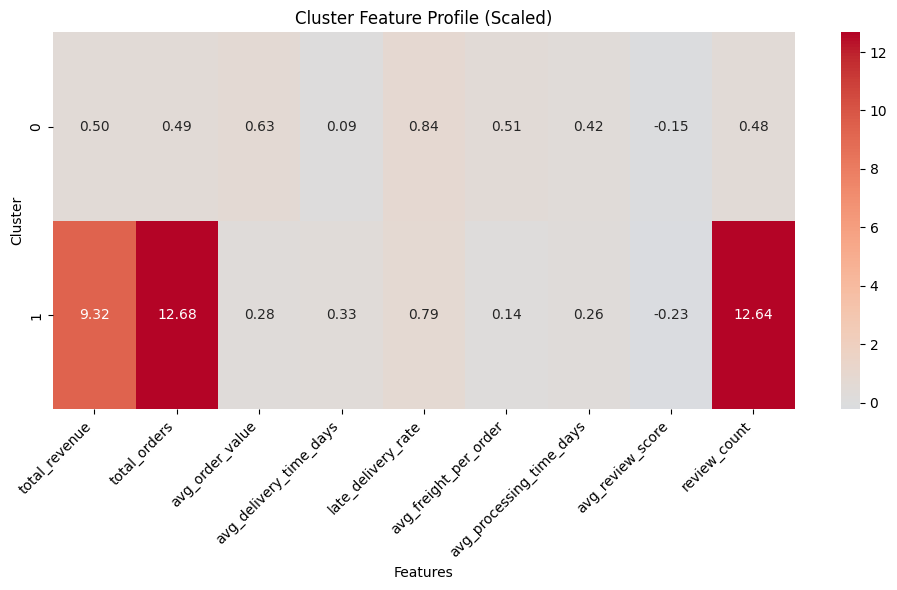

In [26]:
plt.figure(figsize=(10,6))

sns.heatmap(
    cluster_means_scaled,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)

plt.title("Cluster Feature Profile (Scaled)")
plt.ylabel("Cluster")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(image_path, "revenue_concentration_heatmap.png"), dpi=300, bbox_inches="tight")
plt.show()

# Behaviour Analysis

### Since in the initial approach the clustering was heavily influenced by features like total_revenue  & total_order.Lets try clustering without these features  

In [27]:
BEHAVIOR_COLS = [
    "avg_order_value",
    "avg_delivery_time_days",
    "late_delivery_rate",
    "avg_freight_per_order",
    "avg_processing_time_days",
    "avg_review_score"
]
df_behavior = df.drop(['seller_segment','labels'],axis=1).copy()

for col in BEHAVIOR_COLS:
    q99 = df_behavior[col].quantile(0.99)
    q01 = df_behavior[col].quantile(0.01)
    df_behavior[col] = df_behavior[col].clip(lower=q01, upper=q99)

X_behavior = df_behavior[BEHAVIOR_COLS].values

scaler = RobustScaler()
X_behavior_scaled = scaler.fit_transform(X_behavior)

In [35]:
# K_RANGE = range(2, 8)
# sil_scores_behavior = []

# for k in K_RANGE:
#     km2 = KMeans(n_clusters=k, random_state=42, n_init=15)
#     labels_behavior = km2.fit_predict(X_behavior_scaled)
#     sil = silhouette_score(X_behavior_scaled, labels_behavior)
#     sil_scores_behavior.append(sil)
#     print(f"k={k}  silhouette={sil:.4f}")

K_RANGE = range(2, 8)

inertias_behavior = []
sil_scores_behavior = []

for k in K_RANGE:
    km2 = KMeans(n_clusters=k, random_state=42, n_init=15)
    labels_behavior = km2.fit_predict(X_behavior_scaled)

    inertias_behavior.append(km2.inertia_)

    sil = silhouette_score(X_behavior_scaled, labels_behavior)
    sil_scores_behavior.append(sil)

    print(f"k={k}  inertia={km2.inertia_:.2f}  silhouette={sil:.4f}")

k=2  inertia=28211.33  silhouette=0.6140
k=3  inertia=21637.77  silhouette=0.5971
k=4  inertia=19178.22  silhouette=0.4376
k=5  inertia=17009.76  silhouette=0.3555
k=6  inertia=15540.06  silhouette=0.2760
k=7  inertia=14296.20  silhouette=0.2974


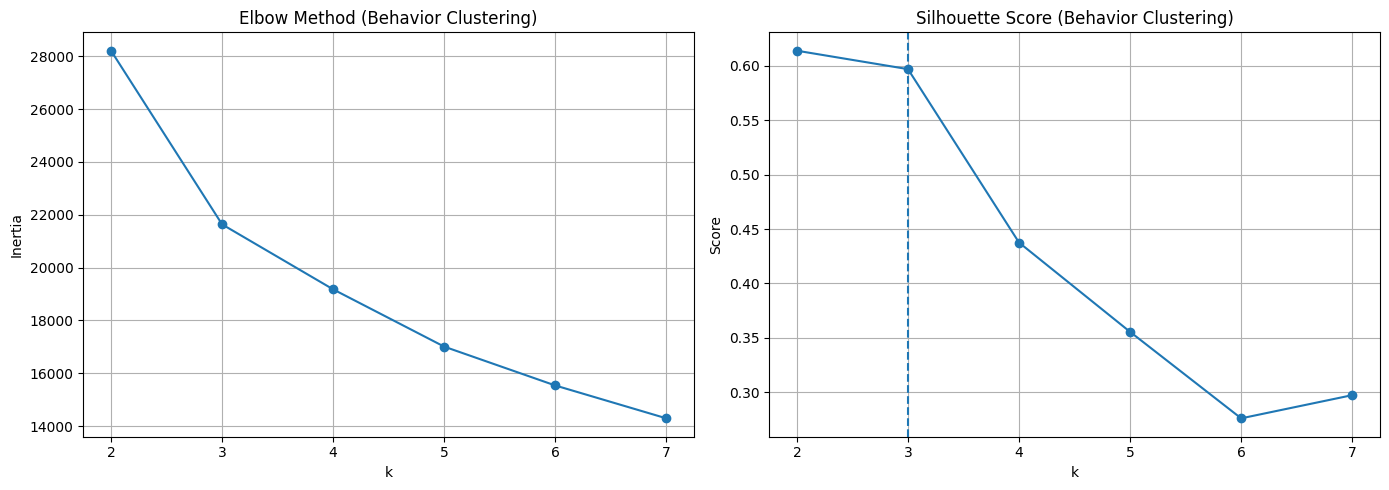

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
axes[0].plot(list(K_RANGE), inertias_behavior, marker='o')
axes[0].set_title("Elbow Method (Behavior Clustering)")
axes[0].set_xlabel("k")
axes[0].set_ylabel("Inertia")
axes[0].grid(True)

# Silhouette
axes[1].plot(list(K_RANGE), sil_scores_behavior, marker='o')
axes[1].axvline(3, linestyle="--")
axes[1].set_title("Silhouette Score (Behavior Clustering)")
axes[1].set_xlabel("k")
axes[1].set_ylabel("Score")
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(image_path, "behavior_elbow_silhouette.png"),
            dpi=300, bbox_inches="tight")
plt.show()

In [29]:
best_k_behavior = 3

km_behavior = KMeans(n_clusters=best_k_behavior, random_state=42, n_init=15)
labels_behavior = km_behavior.fit_predict(X_behavior_scaled)


df_behavior["behavior_cluster"] = labels_behavior
behavior_segment_names = {
    0: "Efficient Sellers",
    1: "Premium Sellers",
    2: "Struggling Sellers"
}

df_behavior["behavior_segment"] = df_behavior["behavior_cluster"].map(behavior_segment_names)

In [30]:
behavior_profile = df_behavior.groupby("behavior_cluster")[BEHAVIOR_COLS].mean().round(2)
behavior_profile['segment_names'] = behavior_profile.index.map(behavior_segment_names)
behavior_profile = behavior_profile.set_index('segment_names')
behavior_profile

,avg_order_value,avg_delivery_time_days,late_delivery_rate,avg_freight_per_order,avg_processing_time_days,avg_review_score
segment_names,,,,,,
Efficient Sellers,129.28,7.98,0.05,22.59,2.71,4.25
Premium Sellers,924.97,9.55,0.08,71.83,3.89,4.13
Struggling Sellers,187.89,13.41,0.64,27.22,9.12,2.93


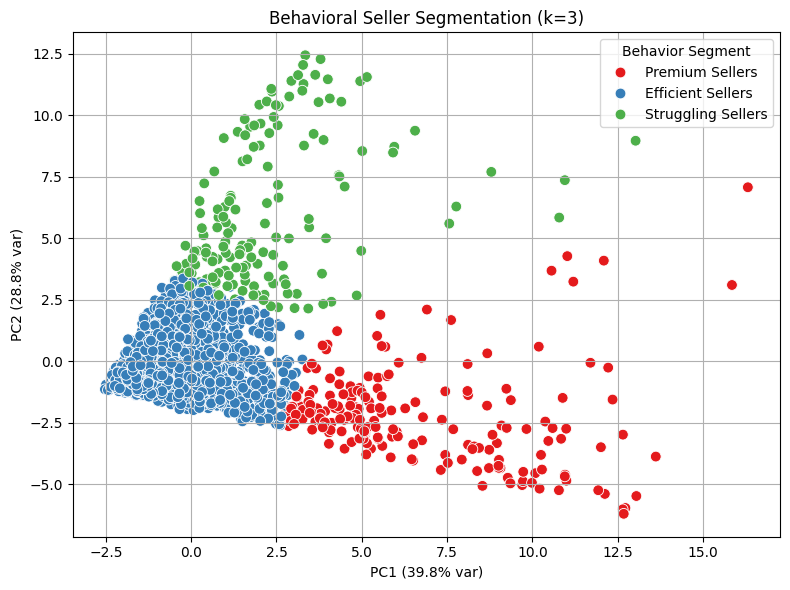

In [32]:
pca_behavior = PCA(n_components=2, random_state=42)
X_behavior_pca = pca_behavior.fit_transform(X_behavior_scaled)

pca_behavior_df = pd.DataFrame(
    X_behavior_pca,
    columns=["PC1", "PC2"]
)

pca_behavior_df["behavior_segment"] = df_behavior["behavior_segment"]

plt.figure(figsize=(8,6))

sns.scatterplot(
    data=pca_behavior_df,
    x="PC1",
    y="PC2",
    hue="behavior_segment",
    palette="Set1",
    s=60
)

plt.title("Behavioral Seller Segmentation (k=3)")
plt.xlabel(f"PC1 ({pca_behavior.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_behavior.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Behavior Segment")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(image_path, "behavioural_seg_pca_k3.png"), dpi=300, bbox_inches="tight")
plt.show()

In [33]:
# Export seller feature matrix
seller_features.to_csv(os.path.join(metrices_path, "seller_features.csv"), index=False)

# Export scale-based clustering results
df.to_csv(os.path.join(metrices_path, "seller_clusters_scale.csv"), index=False)

# Export cluster means (scale-based)
cluster_means.to_csv(os.path.join(metrices_path, "cluster_means_scale.csv"))

# Export behavioral clustering results
behavior_profile.to_csv(os.path.join(metrices_path, "cluster_means_behavior_.csv"))

print(f"\nAll results exported to: {export_path}")


All results exported to: ./exports/revenue
